In [1]:
import cv2
import torch
import numpy as np
import albumentations as albu
import matplotlib.pyplot as plt

from face_segmentation.model_training.datasets.people_dataset import PeopleDataset
from face_segmentation.model_training.augmentations.augmentations import get_transforms

In [2]:
path = "C:\\Users\\andrii.prysiazhnyk\\Documents\\data\\computer_vision\\face_seg\\split_data\\train"

### Augmentations

In [4]:
transform_config = {"size": 224,
                    "augmentation_scope": "none",
                    "size_transform": "resize",
                    "images_normalization": "none",
                    "masks_normalization": "binary",
                    "images_output_format_type": "float",
                    "masks_output_format_type": "long"}

transform = get_transforms(transform_config)

In [5]:
ds = PeopleDataset(path, transform)

In [6]:
dl = torch.utils.data.DataLoader(ds, batch_size=32)

In [7]:
x, y = iter(dl).next()

In [8]:
x.shape, x.dtype

(torch.Size([32, 3, 224, 224]), torch.float32)

In [9]:
y.shape, y.dtype

(torch.Size([32, 224, 224]), torch.int64)

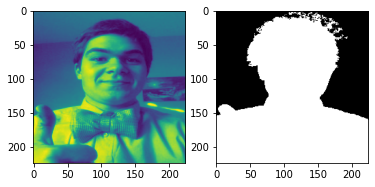

In [10]:
plt.subplot(1, 2, 1)
plt.imshow(x[1].permute(1, 2, 0)[:, :, 1])
plt.subplot(1, 2, 2)
plt.imshow(y[1], cmap="gray")

### Models

In [2]:
from torchsummary import summary
from face_segmentation.model_training.models import get_network, load_network

In [4]:
model_config = {"arch": "unet",
                "encoder": "resnet34",
                "encoder_weights": "imagenet"}

In [5]:
model = get_network(model_config)

In [6]:
y_hat = model(x)

NameError: name 'x' is not defined

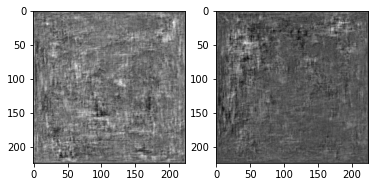

In [23]:
plt.subplot(1, 2, 1)
plt.imshow(y_hat[0, 0].detach(), cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(y_hat[15, 0].detach(), cmap="gray")

In [14]:
y_hat.shape, y_hat.dtype

(torch.Size([32, 1, 224, 224]), torch.float32)

In [28]:
torch.save(model.extended_state_dict(), "model.pth")

In [30]:
model = load_network("model.pth")

### Losses

In [17]:
from face_segmentation.model_training.losses.dice_loss import DiceLoss
from face_segmentation.model_training.losses.focal_loss import FocalLoss
from torch.nn import BCEWithLogitsLoss

from face_segmentation.model_training.losses import get_loss_fn

In [18]:
y_hat.shape, y.shape

(torch.Size([32, 1, 224, 224]), torch.Size([32, 224, 224]))

In [19]:
loss_config = [{"name": "dice", "weight": 0.25},
               {"name": "bce", "weight": 0.5},
               {"name": "focal", "alpha": 1, "weight": 0.25}]

In [20]:
criterion = get_loss_fn(loss_config)

In [21]:
loss = criterion(y_hat, y)

In [22]:
loss

tensor(0.4920, grad_fn=<AddBackward0>)

### Metrics

In [23]:
from face_segmentation.model_training.metrics import get_metric

In [24]:
iou_fn = get_metric("iou")

In [25]:
iou_score = iou_fn(y_hat, y)

In [27]:
iou_score

0.5281574130058289

### Inference

In [14]:
from skimage.transform import resize
from skimage import img_as_bool

In [3]:
model = load_network("model.pth")

In [4]:
test_path = "C:\\Users\\andrii.prysiazhnyk\\Documents\\data\\computer_vision\\face_seg\\test"

In [5]:
transforms = {"size": 224,
              "augmentation_scope": "none",
              "images_normalization": "default",
              "images_output_format_type": "float",
              "masks_normalization": "binary",
              "masks_output_format_type": "long",
              "size_transform": "resize"}
transform = get_transforms(transforms)

In [6]:
test_ds = PeopleDataset(test_path, transform, False)

In [7]:
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=32)

In [8]:
len(test_ds)

2177

In [39]:
import os

In [41]:
counter = 0
masks_path = "C:\\Users\\andrii.prysiazhnyk\\Documents\\data\\computer_vision\\face_seg\\test\\masks"

for x_original, x, ids in test_dl:
    print(f"Processing {counter + 1}/{len(test_dl)}")
    with torch.no_grad():
        y = model(x)
        y = (y.squeeze(1) > 0).long()
        y = y.numpy().astype(np.bool)
    
    for i in range(ids.shape[0]):
        y_cur = y[i]
        y_cur = img_as_bool(resize(y_cur, (320, 240))).astype(np.uint8)
        y_cur[y_cur == 1] = 255
        cv2.imwrite(os.path.join(masks_path, f"{ids[i].item()}.png"), y_cur)
    
    counter += 1

Processing 1/69
Processing 2/69
Processing 3/69
Processing 4/69
Processing 5/69
Processing 6/69
Processing 7/69
Processing 8/69
Processing 9/69
Processing 10/69
Processing 11/69
Processing 12/69
Processing 13/69
Processing 14/69
Processing 15/69
Processing 16/69
Processing 17/69
Processing 18/69
Processing 19/69
Processing 20/69
Processing 21/69
Processing 22/69
Processing 23/69
Processing 24/69
Processing 25/69
Processing 26/69
Processing 27/69
Processing 28/69
Processing 29/69
Processing 30/69
Processing 31/69
Processing 32/69
Processing 33/69
Processing 34/69
Processing 35/69
Processing 36/69
Processing 37/69
Processing 38/69
Processing 39/69
Processing 40/69
Processing 41/69
Processing 42/69
Processing 43/69
Processing 44/69
Processing 45/69
Processing 46/69
Processing 47/69
Processing 48/69
Processing 49/69
Processing 50/69
Processing 51/69
Processing 52/69
Processing 53/69
Processing 54/69
Processing 55/69
Processing 56/69
Processing 57/69
Processing 58/69
Processing 59/69
Proces

In [9]:
x_original, x, ids = iter(test_dl).next()

In [10]:
x.shape, x_original.shape, ids.shape

(torch.Size([32, 3, 224, 224]),
 torch.Size([32, 320, 240, 3]),
 torch.Size([32]))

In [11]:
x.dtype, x_original.dtype, ids.dtype

(torch.float32, torch.uint8, torch.int64)

In [37]:
ids[0].item()

1492

In [12]:
with torch.no_grad():
    y = model(x)
    y = (y.squeeze(1) > 0).long()
    y = y.numpy().astype(np.bool)

In [26]:
y1 = y[22]
y1 = img_as_bool(resize(y1, (320, 240))).astype(np.uint8)
x1 = x_original[22].numpy()

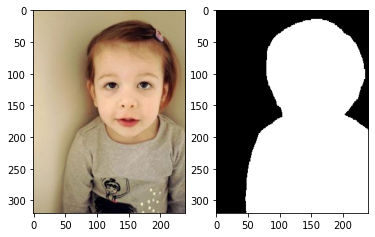

In [27]:
plt.subplot(1, 2, 1)
plt.imshow(x1[:, :, ::-1])
plt.subplot(1, 2, 2)
plt.imshow(y1, cmap="gray")

In [31]:
cv2.imwrite("image_processed.png", y1)

True

In [29]:
y1[y1 == 1] = 255

In [30]:
y1

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255]], dtype=uint8)